In [1]:
from transformers import pipeline

In [3]:
depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

In [4]:
from PIL import Image

In [5]:
raw_image = Image.open('../data/town.jpeg')

In [6]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[2072.0225, 2054.2434, 2072.1963,  ...,  259.7062,  256.2417,
            201.7430],
          [2025.1023, 2063.7908, 2076.2751,  ...,  262.8618,  259.2101,
            258.5185],
          [2077.7849, 2073.4487, 2077.9956,  ...,  263.1832,  263.5771,
            261.7879],
          ...,
          [3366.7090, 3370.7607, 3361.9329,  ..., 3731.8406, 3712.6284,
           3707.4084],
          [3378.9780, 3374.2266, 3374.9956,  ..., 3729.8704, 3725.9973,
           3698.2480],
          [3373.4629, 3379.9636, 3373.2605,  ..., 3746.2153, 3729.8872,
           3706.3125]]]),
 'depth': <PIL.Image.Image image mode=L size=768x512>}

In [7]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

Lets resize it to the original shape

In [10]:
# we need to have the number of channels as the first dimension in order to use the torch library
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [16]:
import torch

prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [17]:
prediction.shape

torch.Size([1, 1, 512, 768])

Same shape as the input image but the values if we print the predictions is not normalized (not in range 0-255) so we will normalize them

In [18]:
prediction

tensor([[[[2077.6931, 2069.7991, 2056.5696,  ...,  242.4423,  210.7688,
            191.5125],
          [2033.7893, 2040.9095, 2052.4468,  ...,  252.7135,  242.0808,
            235.5949],
          [2034.8119, 2044.3088, 2059.8323,  ...,  261.9456,  264.7235,
            266.3943],
          ...,
          [3375.9363, 3375.1519, 3373.8857,  ..., 3714.7542, 3704.3672,
           3697.9956],
          [3378.5139, 3377.9922, 3377.1433,  ..., 3721.6570, 3706.4202,
           3697.1184],
          [3372.2961, 3374.9771, 3379.4832,  ..., 3723.0767, 3711.5588,
           3704.4365]]]])

In [19]:
import numpy as np
output = prediction.squeeze().numpy() # remove the first dimension for plotting
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

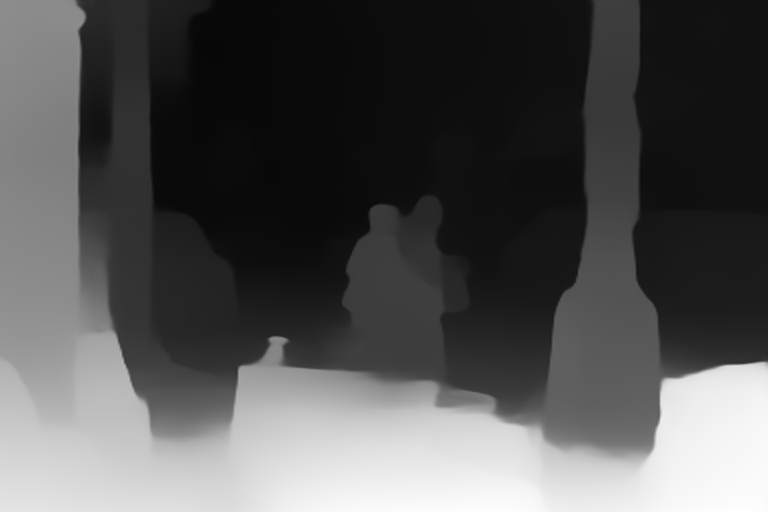

In [20]:
depth

In [21]:
output

array([[2077.693  , 2069.799  , 2056.5696 , ...,  242.44226,  210.76884,
         191.51254],
       [2033.7893 , 2040.9095 , 2052.4468 , ...,  252.71349,  242.08083,
         235.59494],
       [2034.8119 , 2044.3088 , 2059.8323 , ...,  261.94562,  264.7235 ,
         266.39426],
       ...,
       [3375.9363 , 3375.1519 , 3373.8857 , ..., 3714.7542 , 3704.3672 ,
        3697.9956 ],
       [3378.514  , 3377.9922 , 3377.1433 , ..., 3721.657  , 3706.4202 ,
        3697.1184 ],
       [3372.2961 , 3374.977  , 3379.4832 , ..., 3723.0767 , 3711.5588 ,
        3704.4365 ]], dtype=float32)

In [22]:
prediction

tensor([[[[2077.6931, 2069.7991, 2056.5696,  ...,  242.4423,  210.7688,
            191.5125],
          [2033.7893, 2040.9095, 2052.4468,  ...,  252.7135,  242.0808,
            235.5949],
          [2034.8119, 2044.3088, 2059.8323,  ...,  261.9456,  264.7235,
            266.3943],
          ...,
          [3375.9363, 3375.1519, 3373.8857,  ..., 3714.7542, 3704.3672,
           3697.9956],
          [3378.5139, 3377.9922, 3377.1433,  ..., 3721.6570, 3706.4202,
           3697.1184],
          [3372.2961, 3374.9771, 3379.4832,  ..., 3723.0767, 3711.5588,
           3704.4365]]]])

In [23]:
import os
import gradio as gr
from transformers import pipeline

def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [24]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

In [25]:
iface.launch(share=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [26]:
iface.close()

Closing server running on port: 7860
